In [1]:
import sys

!{sys.executable} -m pip install torch
!{sys.executable} -m pip install qiskit
!{sys.executable} -m pip install pylatexenc
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install itertools

You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.


You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools
You should consider upgrading via the '/usr

In [2]:
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn

In [3]:
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np

In [4]:
from tqdm import tqdm

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

In [27]:
np.random.seed = 42

# np.random.seed(123)

torch.manual_seed(123)

import random
random.seed(123)

NUM_QUBITS = 6
NUM_SHOTS = 5000
SHIFT = np.pi/4
LEARNING_RATE = 0.01
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('qasm_simulator')

In [7]:
# create list of all possible outputs of quantum circuit (2**NUM_QUBITS possible)
import itertools

def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['000000', '000001', '000010', '000011', '000100', '000101', '000110', '000111', '001000', '001001', '001010', '001011', '001100', '001101', '001110', '001111', '010000', '010001', '010010', '010011', '010100', '010101', '010110', '010111', '011000', '011001', '011010', '011011', '011100', '011101', '011110', '011111', '100000', '100001', '100010', '100011', '100100', '100101', '100110', '100111', '101000', '101001', '101010', '101011', '101100', '101101', '101110', '101111', '110000', '110001', '110010', '110011', '110100', '110101', '110110', '110111', '111000', '111001', '111010', '111011', '111100', '111101', '111110', '111111']


# Contruct QuantumCircuit QFT Class

In [8]:
class QuantumCircuit:
    def __init__(self, n_qubits, backend, shots):
        self.n_qubits = n_qubits
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.thetas = { k: Parameter('Theta'+str(k)) for k in range(self.n_qubits) }
        
        all_qubits = [i for i in range(n_qubits)]
        
        self.circuit.h(all_qubits)
        self.circuit.barrier()
        for k in range(n_qubits):
            self.circuit.ry(self.thetas[k], k)
            
        self.circuit.measure_all()
        
        self.backend = backend
        self.shots = shots
        
    def N_qubits_expectation_Z(self, counts, shots, n_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0) / shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
        
        backend = Aer.get_backend('qasm_simulator')
        
        job_sim = execute(self.circuit, 
                          self.backend, 
                          shots = self.shots, 
                          parameter_binds = [{ self.thetas[k]: params[k].item() for k in range(self.n_qubits) }])
        
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        
        return self.N_qubits_expectation_Z(counts, self.shots, self.n_qubits)

Expected value for rotation [pi/4]: [0.000e+00 0.000e+00 2.000e-04 8.000e-04 0.000e+00 4.000e-04 2.000e-04
 2.400e-03 0.000e+00 2.000e-04 4.000e-04 2.000e-03 0.000e+00 1.400e-03
 2.000e-03 1.380e-02 0.000e+00 0.000e+00 0.000e+00 2.600e-03 6.000e-04
 2.600e-03 1.400e-03 1.140e-02 0.000e+00 1.200e-03 1.600e-03 1.160e-02
 1.200e-03 1.200e-02 1.100e-02 6.600e-02 0.000e+00 6.000e-04 0.000e+00
 2.200e-03 2.000e-04 2.200e-03 2.000e-03 1.140e-02 8.000e-04 2.000e-03
 1.000e-03 1.320e-02 2.000e-03 1.000e-02 1.200e-02 6.240e-02 2.000e-04
 1.600e-03 1.800e-03 1.400e-02 2.200e-03 1.060e-02 1.060e-02 5.360e-02
 1.400e-03 1.360e-02 1.180e-02 6.940e-02 1.280e-02 6.620e-02 6.500e-02
 3.962e-01]


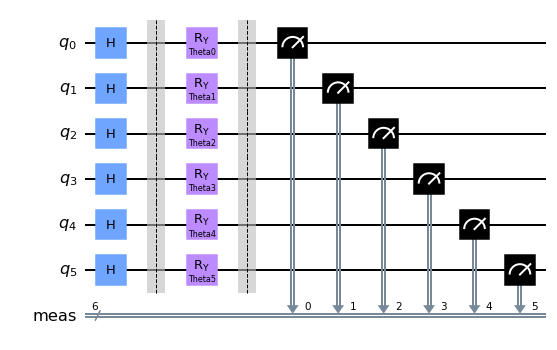

In [9]:
circuit = QuantumCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
print(f'Expected value for rotation [pi/4]: {circuit.run(torch.Tensor([np.pi/4] * len(QC_OUTPUTS)))}')
circuit.circuit.draw(output='mpl')

In [10]:
class TorchCircuit(Function):
    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QuantumCircuit'):
            ctx.QuantumCircuit = QuantumCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
        
        exp_value = ctx.QuantumCircuit.run(i)
        
        result = torch.Tensor([exp_value])
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        forward_tensor,i = ctx.saved_tensors
        
        input_numbers = i
        gradients = torch.Tensor()
        
        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
            expectation_right = ctx.QuantumCircuit.run(shift_right)
            expectation_left = ctx.QuantumCircuit.run(shift_left)
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradient = gradient / torch.norm(gradient)
            
            gradients = torch.cat((gradients, gradient.float()))
            
        result = torch.Tensor(gradients)
        
        return (result.float() * grad_output.float()).T

In [11]:
x = torch.tensor([np.pi/4] * NUM_QUBITS, requires_grad=True)
qc = TorchCircuit.apply

y1 = qc(x)
print(f'y1 after quantum layer: {y1}')
y1 = nn.Linear(2**NUM_QUBITS, 1)(y1.float())

y1.backward()
print(f'x.grad = {x.grad}')

y1 after quantum layer: tensor([[0.0000e+00, 0.0000e+00, 4.0000e-04, 2.0000e-04, 0.0000e+00, 2.0000e-04,
         2.0000e-04, 2.4000e-03, 0.0000e+00, 4.0000e-04, 4.0000e-04, 2.8000e-03,
         8.0000e-04, 1.2000e-03, 2.0000e-03, 1.3000e-02, 2.0000e-04, 4.0000e-04,
         6.0000e-04, 2.6000e-03, 2.0000e-04, 2.0000e-03, 1.0000e-03, 1.2000e-02,
         4.0000e-04, 2.8000e-03, 1.2000e-03, 1.1600e-02, 2.2000e-03, 1.4200e-02,
         1.2400e-02, 6.5400e-02, 2.0000e-04, 4.0000e-04, 6.0000e-04, 2.0000e-03,
         0.0000e+00, 2.4000e-03, 2.2000e-03, 1.2400e-02, 1.0000e-03, 2.0000e-03,
         1.6000e-03, 9.0000e-03, 2.4000e-03, 1.1400e-02, 1.0200e-02, 6.2400e-02,
         2.0000e-04, 1.4000e-03, 1.2000e-03, 1.0800e-02, 1.2000e-03, 1.0600e-02,
         1.2000e-02, 6.5000e-02, 1.4000e-03, 1.4200e-02, 1.0400e-02, 6.7600e-02,
         1.0600e-02, 6.7000e-02, 6.2600e-02, 3.9040e-01]],
       grad_fn=<TorchCircuitBackward>)
x.grad = tensor([ 0.0010, -0.0773, -0.1148, -0.0034, -0.0157, -0.104

100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


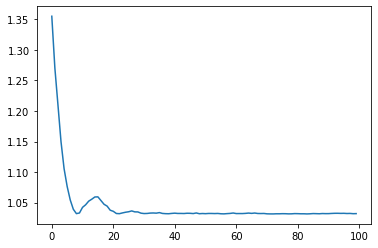

In [12]:
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)[0]
    
    val = sum([(i + 1) * expval[i] for i in range(2**NUM_QUBITS)]) / 2**NUM_QUBITS
    
    return torch.abs(target - val) ** 2, expval


x = torch.tensor([-np.pi/4] * NUM_QUBITS, requires_grad=True)
opt = optim.Adam([x], lr = 0.1)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval)
    
plt.plot(loss_list)

In [13]:
from torch.functional import F

In [14]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

n_samples = 150

X_train = datasets.FashionMNIST(root='./data', 
                                train=True,
                                download=True,
                                transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 2)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 3)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 4)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 5)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 6)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 7)[0][:n_samples])
# idx = np.append(idx, 
#                 np.where(X_train.targets == 8)[0][:n_samples])
# idx = np.append(idx, 
#                 np.where(X_train.targets == 9)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

In [15]:
train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

In [16]:
n_samples = 100

X_test = datasets.FashionMNIST(root='./data', 
                               train=False,
                               download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 2)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 3)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 4)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 5)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 6)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 7)[0][:n_samples])
# idx = np.append(idx, 
#                 np.where(X_test.targets == 8)[0][:n_samples])
# idx = np.append(idx, 
#                 np.where(X_test.targets == 9)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

In [17]:
test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

# Building network

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, NUM_QUBITS)
        self.qc = TorchCircuit.apply
        self.qcsim = nn.Linear(NUM_QUBITS, 2**NUM_QUBITS)
        
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = np.pi*torch.tanh(x)
        
        MODE = 'QC'
        
        if MODE == 'QC':
            x = self.qc(x[0])
        else:
            x = self.qcsim(x)
            
        x = torch.sigmoid(x)
        x = torch.cat((x, 1-x), -1)
        
        return x
    
    
    def predict(self, x):
        
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        
        return torch.tensor(ans)
    
network = Net()
optimizer = optim.Adam(network.parameters(), lr=0.001)

In [19]:
epochs = 15
loss_list = []
loss_func = nn.CrossEntropyLoss()

for epoch in range(epochs):
    total_loss = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss.append(loss.item())
        
    loss_list.append(sum(total_loss) / len(total_loss))
    progress = 100.0 * (epoch + 1) / epochs
    
    print(f'Training [{int(progress)}%]\tLoss {loss_list[-1]}')

Training [6%]	Loss 4.792422393957774
Training [13%]	Loss 4.759184662501017
Training [20%]	Loss 4.744032804171244
Training [26%]	Loss 4.735637442668279
Training [33%]	Loss 4.728296837409338
Training [40%]	Loss 4.723126686811447
Training [46%]	Loss 4.724437764883041
Training [53%]	Loss 4.721098405122757
Training [60%]	Loss 4.722422817548116
Training [66%]	Loss 4.720316509405772
Training [73%]	Loss 4.717362840175628
Training [80%]	Loss 4.718330937226614
Training [86%]	Loss 4.718648339112599
Training [93%]	Loss 4.717322378953298
Training [100%]	Loss 4.714719281991322


Text(0, 0.5, 'loss')

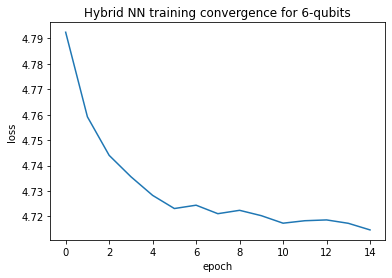

In [20]:
plt.plot(loss_list)
plt.title(f'Hybrid NN training convergence for {NUM_QUBITS}-qubits')
plt.xlabel('epoch')
plt.ylabel('loss')

# Test accuracy

In [21]:
accuracy = 0
number = 0
for batch_idx, (data, target) in enumerate(test_loader):
    number += 1
    output = network.predict(data).item()
    accuracy += (output == target[0].item())*1

In [22]:
print(f'Performance on test data: {accuracy}/{number} = {accuracy/number*100}%')

Performance on test data: 540/800 = 67.5%


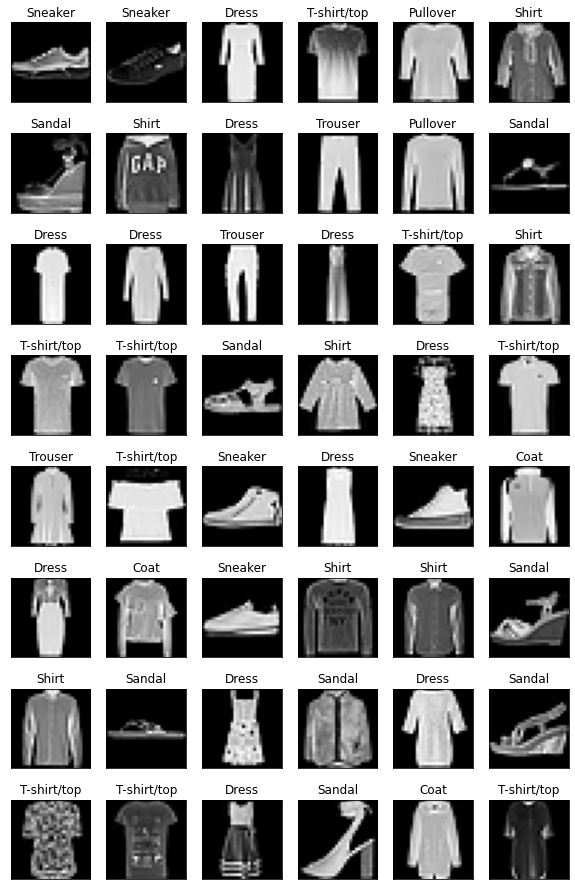

In [23]:
n_sample_shape = (8, 6)
count = 0
fig, axes = plt.subplots(nrows=n_sample_shape[0], ncols=n_sample_shape[1], figsize=(10, 2*n_sample_shape[0]))

classes_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

network.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_sample_shape[0]*n_sample_shape[1]:
            break
        
        prediction = network.predict(data).item()
        
        axes[count // n_sample_shape[1]][count % n_sample_shape[1]].imshow(data[0].numpy().squeeze(), cmap='gray')
        
        axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_xticks([])
        axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_yticks([])
        axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_title(classes_map[prediction])
        
        count += 1

In [24]:
def train_network(network, optimizer, train_loader, val_loader):
    epochs = 15
    loss_func = nn.CrossEntropyLoss()

    loaders = {
        'train': train_loader,
        'val': val_loader
    }
    
    loss_results = {
        'train': [],
        'val': []
    }

    acc_results = {
        'train': [],
        'val': []
    }

    loaders = {
        'train': train_loader,
        'val': test_loader
    }

    for epoch in range(epochs):
        total_loss = {
            'train': [],
            'val': []
        }

        total_acc = {
            'train': [],
            'val': []
        }


        for phase in ['train', 'val']:
            if phase == 'train':
                network.train(True)
            else:
                network.train(False)

            correct = 0
            number = 0

            for batch_idx, (data, target) in enumerate(loaders[phase]):
                optimizer.zero_grad()
                output = network(data)

                loss = loss_func(output, target)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                total_loss[phase].append(loss.item())

                _, predicted = torch.max(output.data, 1)
                number += target.size(0)
                correct += (predicted == target).sum().item()

            loss_results[phase].append(sum(total_loss[phase]) / len(total_loss[phase]))
            acc_results[phase].append(100 * correct / number)

        progress = 100.0 * (epoch + 1) / epochs

        print(f'Training [{int(progress)}%]\tTraining loss {loss_results["train"][-1]}\tValidation loss {loss_results["val"][-1]}\tTraining acc {acc_results["train"][-1]}\tValidation acc {acc_results["val"][-1]}')
        
    return {
        'train_loss': loss_results["train"][-1],
        'val_loss': loss_results["val"][-1],
        'train_acc': acc_results["train"][-1],
        'val_acc': acc_results["val"][-1]
    }

In [28]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, ConcatDataset

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

dataset = ConcatDataset([X_train, X_test])

k_folds = 5

kfold = KFold(n_splits=k_folds, shuffle=True)

results = {}

print('--------------------------------')

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
  
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=1, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=1, sampler=test_subsampler)

    network = Net()
    network.apply(reset_weights)
    
    optimizer = optim.Adam(network.parameters(), lr=0.001)
    
    result = train_network(network, optimizer, trainloader, testloader)
    
    results[fold] = result
    
    print(result)
    print('--------------------------------')

print('--------------------------------')
print('FINAL RESULTS')
print('--------------------------------')
print(results)
    

--------------------------------
FOLD 0
--------------------------------
Training [6%]	Training loss 4.793580022752285	Validation loss 4.733403714299202	Training acc 31.5	Validation acc 60.75
Training [13%]	Training loss 4.753083605766296	Validation loss 4.708440843820572	Training acc 54.375	Validation acc 67.5
Training [20%]	Training loss 4.737878310382366	Validation loss 4.701533563137055	Training acc 60.6875	Validation acc 69.875
Training [26%]	Training loss 4.7342365795373915	Validation loss 4.703016383647919	Training acc 61.5	Validation acc 70.375
Training [33%]	Training loss 4.730241015851497	Validation loss 4.700704622268677	Training acc 63.875	Validation acc 69.625
Training [40%]	Training loss 4.726357751190663	Validation loss 4.695621470808983	Training acc 64.3125	Validation acc 73.125
Training [46%]	Training loss 4.726350745558738	Validation loss 4.698930863142014	Training acc 63.6875	Validation acc 73.125
Training [53%]	Training loss 4.725333437621593	Validation loss 4.69409

Training [13%]	Training loss 4.755455719232559	Validation loss 4.725504302978516	Training acc 51.0625	Validation acc 59.75
Training [20%]	Training loss 4.741582338511944	Validation loss 4.71038416326046	Training acc 58.9375	Validation acc 66.625
Training [26%]	Training loss 4.735334078371525	Validation loss 4.70150865316391	Training acc 61.4375	Validation acc 68.875
Training [33%]	Training loss 4.72949513554573	Validation loss 4.699352105259895	Training acc 63.8125	Validation acc 73.375
Training [40%]	Training loss 4.728236000537873	Validation loss 4.698872135281563	Training acc 64.125	Validation acc 71.25
Training [46%]	Training loss 4.724111997485161	Validation loss 4.693079174160958	Training acc 66.3125	Validation acc 75.0
Training [53%]	Training loss 4.723282354474068	Validation loss 4.688758843541145	Training acc 65.6875	Validation acc 76.625
Training [60%]	Training loss 4.720260644257069	Validation loss 4.690681859254837	Training acc 67.25	Validation acc 75.75
Training [66%]	Trai